# Decision trees with *sklearn*

Idea of this notebook to make an intuition of how works a decision tree. We will consider decision tree as a classifier.

## Theory

A lot of sources can be found about decision trees. Here we follow [sklearn description](http://scikit-learn.org/stable/modules/tree.html#mathematical-formulation) and apply it on several examples.


> Given training vectors $x_i \in R^n, i=1,..., l$ and a label vector $y \in R^l$, a decision tree recursively partitions the space such that the samples with the same labels are grouped together.

> Let the data at node $m$ be represented by $Q$. For each candidate split $\theta = (j, t_m)$ consisting of a feature $j$ and threshold $t_m$, partition the data into $Q_{left}(\theta)$ and $Q_{right}(\theta)$ subsets

> $$Q_{left}(\theta) = {(x, y) | x_j <= t_m}$$
> $$Q_{right}(\theta) = Q \setminus Q_{left}(\theta)$$

> The impurity at $m$ is computed using an impurity function $H()$, the choice of which depends on the task being solved (classification or regression)

> $$G(Q, \theta) = \frac{n_{left}}{N_m} H(Q_{left}(\theta)) + \frac{n_{right}}{N_m} H(Q_{right}(\theta))$$

> Select the parameters that minimises the impurity

> $$\theta^* = \operatorname{argmin}_\theta G(Q, \theta)$$

> Recurse for subsets $Q_{left}(\theta^*)$ and $Q_{right}(\theta^*)$ until the maximum allowable depth is reached, $N_m < \min_{samples}$ or $N_m = 1$.

> ** Classification criteria **

> If a target is a classification outcome taking on values $0,1,...,K-1$, for node $m$, representing a region $R_m$ with $N_m$ observations, let

> $$p_{mk} = 1/ N_m \sum_{x_i \in R_m} I(y_i = k)$$

> be the proportion of class $k$ observations in node $m$

> Common measures of impurity are Gini

> $$H(X_m) = \sum_k p_{mk} (1 - p_{mk})$$

> Cross-Entropy

> $$H(X_m) = - \sum_k p_{mk} \log(p_{mk})$$

> and Misclassification

> $$H(X_m) = 1 - \max(p_{mk})$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Synthetic examples

#### A) Single feature example
Let's take the simplest classification example with 1D training vectors $n=1$, for example, $x_i = \sin(0.123 \times i)$ and $y_i = sign(x_i), i=0,...,99$

In [2]:
t = np.arange(100)
x = np.sin(t*0.123 + 0.0012)
y = np.sign(x); y[y < 0] = 0

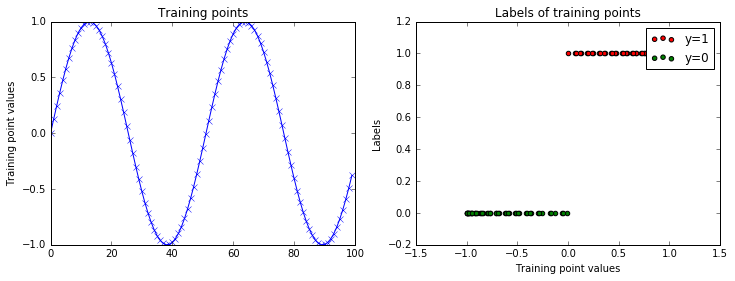

In [3]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Training points")
plt.plot(t, x, 'x-')
plt.ylabel("Training point values")
plt.subplot(122)
plt.title("Labels of training points")
plt.scatter(x[y > 0.5], y[y > 0.5], c='r', label='y=1')
plt.scatter(x[y < 0.5], y[y < 0.5], c='g', label='y=0')
plt.xlabel("Training point values")
plt.ylabel("Labels")
plt.legend()

As it is written in the theory, let us search for the split $\theta=(j,t)$ (in our case $j=0$) such that it minimizes the impurity function. 
At first, we initialize the parameter $t$, for example, $t=-0.25$, then we define the first region `R_0` :

``` python
R_0 = x <= t
```

In [4]:
t = -0.25
R_0 = x <= t

Let us define helper functions to compute $p_{mk}$. In our case, $k$ has two values : `0, 1`

In [19]:
def p_mk(y, k, Rm):
    """
    Method to compute the proportion of class k observations in node m
    """
    Nm = np.sum(Rm)
    if Nm < 1:
        return 0.0
    return 1.0/Nm * np.sum(y[Rm] == k)

In [20]:
p_mk(y, 0, R_0), p_mk(y, 0, ~R_0)

(1.0, 0.10526315789473684)

In [21]:
p_mk(y, 1, R_0), p_mk(y, 1, ~R_0)

(0.0, 0.894736842105263)

Then we can compute, for example, Gini impurity measure 

In [22]:
def Gini_measure(y, region):
    out = 0
    classes = np.unique(y)
    for k in classes:
        out += p_mk(y, k, region)*(1.0 - p_mk(y, k, region))
    return out

In [23]:
Gini_measure(y, R_0), Gini_measure(y, ~R_0)

(0.0, 0.18836565096952917)

Finally, we can compute total impurity function $G(Q, \theta) = \frac{n_{left}}{N_m} H(Q_{left}(\theta)) + \frac{n_{right}}{N_m} H(Q_{right}(\theta))$ :

In [24]:
def impurity_function(Q, theta, H):
    # Q is a list (x, y)
    region = Q[0] <= theta
    Nm = len(Q[1])
    n_left = np.sum(region)
    n_right = Nm - n_left
    return n_left * 1.0 / Nm * H(Q[1], region) + n_right * 1.0 / Nm * H(Q[1], ~region) 

In [25]:
impurity_function((x, y), -0.25, Gini_measure)

0.10736842105263163

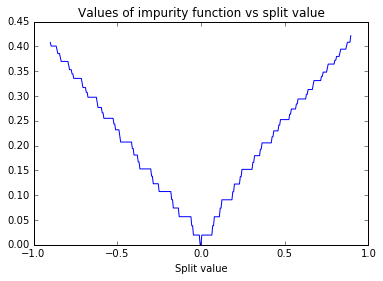

In [26]:
tvals = np.arange(-0.9, 0.9, 0.005)
imp_f_vals = np.zeros(tvals.shape)
for i, t in enumerate(tvals):
    imp_f_vals[i] = impurity_function((x, y), t, Gini_measure)
plt.plot(tvals, imp_f_vals)
plt.title("Values of impurity function vs split value")
plt.xlabel("Split value")

Thus, we see that the minimum of the impurity function is at $t=0.0$ and if we split the dataset at this point we obtain the best split. We can continue to split each subsets, but one of new obtained subsets will be empty.

Let us analyze what are these $p_{mk}$, Gini impurity measure and total impurity function. In the following cell we can configure interactively the value of the split $t$ with a slider and observe values of Gini impurity measure for the left and right parts and total impurity function value. 


**We use `interact` from jupyter, if there is no sliders in the interactive mode, see the warnings in your console.**


Gini impurity measures (left/right parts) : 0.331425598335, 0.0
Total impurity value : 0.205483870968


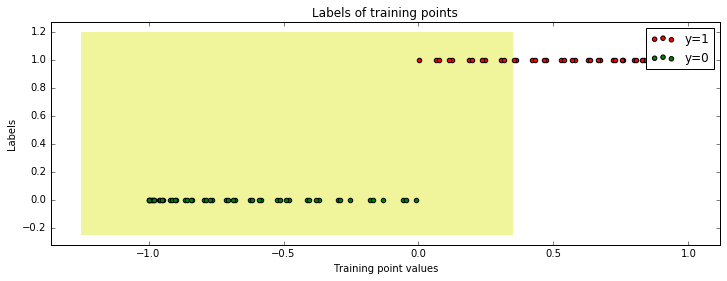

In [33]:
from ipywidgets import interact, FloatSlider

def interactive_split(t):
    
    plt.figure(figsize=(12,4))
    plt.title("Labels of training points")
    
    _x = np.arange(-1.25, t, 0.05)
    _y = np.arange(-0.25, 1.25, 0.05)
    xx, yy  = np.meshgrid(_x, _y)
    zz = np.ones(xx.shape)
    plt.contourf(xx, yy, zz, cmap=plt.cm.Accent)
    
    plt.scatter(x[y > 0.5], y[y > 0.5], c='r', label='y=1')
    plt.scatter(x[y < 0.5], y[y < 0.5], c='g', label='y=0')
    plt.xlabel("Training point values")
    plt.ylabel("Labels")
    plt.legend()   
        
    region = x <= t
    g1 = Gini_measure(y, region)
    g2 = Gini_measure(y, ~region)
    v = impurity_function((x, y), t, Gini_measure)    
    print("Gini impurity measures (left/right parts) : {}, {}".format(g1, g2))
    print("Total impurity value : {}".format(v))
    
interact(
    interactive_split,
    t=FloatSlider(min=-1.0,max=1.0,value=-1.0,step=0.05)
)

#### B) Two features example

Next, let us consider another example with 2 features ($n=2$) and two classes: a point ($x_1$, $x_2$) belong to

* the class 0 if $x_1 > 1.25$ and $x_2 > 2.5$
* the class 1 otherwise

In [35]:
x = 10.0 * np.random.rand(100, 2) - [2.0, 2.0]
y = np.zeros(len(x), dtype=np.int)
condition = (x[:, 0] > 1.25) & (x[:, 1] > 2.5)
y[condition] = 1

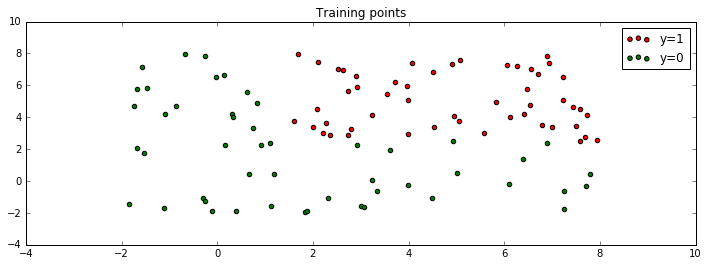

In [70]:
plt.figure(figsize=(12,4))
plt.title("Training points")
plt.scatter(x[condition][:, 0], x[condition][:, 1], c='r', label='y=1')
plt.scatter(x[~condition][:, 0], x[~condition][:, 1], c='g', label='y=0')
plt.legend()

The procedure is similar to the previous case, we begin with the root node level ($m=0$) and we need to find a split $\theta=(j,t_0)$ such that it minimizes the impurity function. Thus, for each feature $j$ we can find optimal value of $t_0$ and, finally, compare the values of impurity functions. 

In [54]:
Q = (x, y)

We need to update `impurity_function` to take into account feature index $j$ :

In [55]:
def impurity_function2(Q, theta, H):
    # Q is (x,y)
    # theta is (j,t)
    region = Q[0][:,theta[0]] <= theta[1]
    Nm = len(Q[1])
    n_left = np.sum(region)
    if Nm < 2 or n_left < 1:
        raise "End of recursion"
    n_right = Nm - n_left
    return n_left * 1.0 / Nm * H(Q[1], region) + n_right * 1.0 / Nm * H(Q[1], ~region) 

In our case, available value of $x_1$ and $x_2$ are almost the same, therefore we can search the value $t$ of the split in the same range:

Index j=0, a minimum found at t=1.19, value=0.287323943662
Index j=1, a minimum found at t=2.49, value=0.231818181818
Theta^* is : [1, 2.4900000000000038]


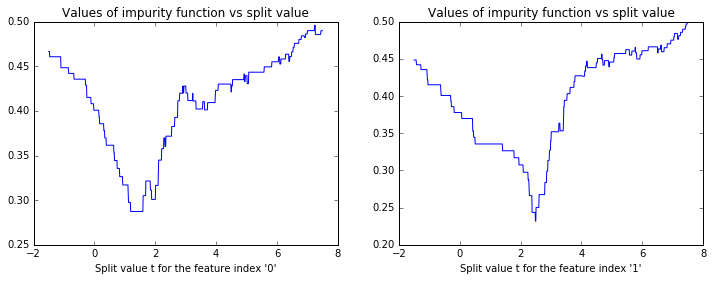

In [56]:
plt.figure(figsize=(12,4))

# Structure to store indices to obtain theta^*
indices_star = [0, 0]

tvals = np.arange(-1.5, 7.5, 0.01)
for j in [0, 1]:
    imp_f_vals = np.zeros(tvals.shape)    
    for i, t in enumerate(tvals):
        imp_f_vals[i] = impurity_function2(Q, (j, t), Gini_measure)
    index_min = np.argmin(imp_f_vals)
    tmin = tvals[index_min]
    
    if imp_f_vals[indices_star[1]] > imp_f_vals[index_min]:
        indices_star[1] = index_min
        indices_star[0] = j
    
    print("Index j={}, a minimum found at t={}, value={}".format(j, tmin, imp_f_vals[index_min]))
    plt.subplot(1,2,j+1)
    plt.plot(tvals, imp_f_vals)
    plt.title("Values of impurity function vs split value")
    plt.xlabel("Split value t for the feature index '%s'" % j)
    
theta_star = [indices_star[0], tvals[indices_star[1]]]
print("Theta^* is : {}".format(theta_star))

From these plots we can conclude that there is a split $\theta^*$ corresponds to the minimum impurity function among other feature indices, so we choose this split as the first split. So, the initial data $Q$ at the root node ($m=0$) is divided into two parts $Q_{left}(\theta^*)$ and $Q_{right}(\theta^*)$ : 

$$Q_{left}(\theta) = {(x, y) | x_j <= t_m}$$
$$Q_{right}(\theta) = Q \setminus Q_{left}(\theta)$$

In [57]:
def divide(Q, theta):
    # Q is (x, y)
    # theta is (j,t)
    mask = Q[0][:,theta[0]] <= theta[1]
    return (Q[0][mask], Q[1][mask]), (Q[0][~mask], Q[1][~mask])

Q_left, Q_right = divide(Q, theta_star)
print(Q_left[0].shape, Q_left[1].shape, "and", Q_right[0].shape, Q_right[1].shape)

((34, 2), (34,), 'and', (66, 2), (66,))


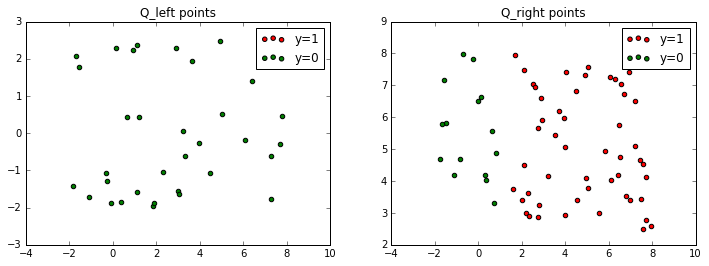

In [73]:
plt.figure(figsize=(12,4))
for i, s, q in zip([1,2], ["left", "right"], [Q_left, Q_right]):
    plt.subplot(1,2,i)
    plt.title("Q_%s points" % s)
    c = q[1] == 1
    plt.scatter(q[0][c][:, 0], q[0][c][:, 1], c='r', label='y=1')
    plt.scatter(q[0][~c][:, 0], q[0][~c][:, 1], c='g', label='y=0')
    plt.legend()

Next, we process iteratively these parts :

Left split: Index j=0, a minimum found at t=-1.8457842778, value=0.0
Left split: Index j=1, a minimum found at t=-1.95997685796, value=0.0
Left split : Theta^* is : [0, -1.9599768579584524]
Right split: Index j=0, a minimum found at t=0.820992197097, value=0.0
Right split: Index j=1, a minimum found at t=3.79238609269, value=0.329124579125
Right split : Theta^* is : [1, 3.7923860926933513]


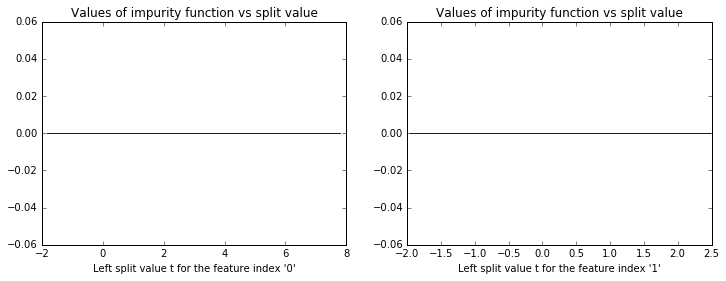

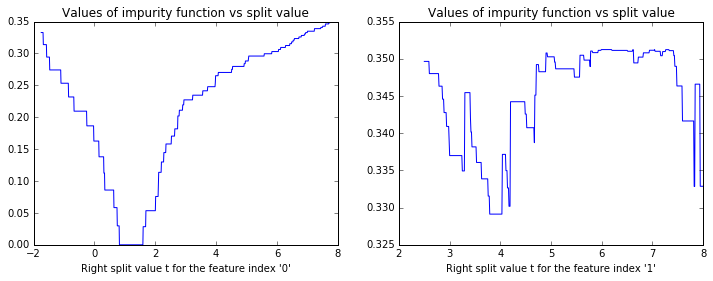

In [76]:
Q = Q_right

for s, Q in zip(['Left', 'Right'], [Q_left, Q_right]):
    plt.figure(figsize=(12,4))

    # Structure to store indices to obtain theta^*
    indices_star = [0, 0]
    for j in [0, 1]:

        # get t value ranges from x stored in Q(theta) 
        tvals = np.arange(Q[0][:,j].min(), Q[0][:,j].max(), 0.01)

        imp_f_vals = np.zeros(tvals.shape)    
        for i, t in enumerate(tvals):
            imp_f_vals[i] = impurity_function2(Q, (j, t), Gini_measure)
        index_min = np.argmin(imp_f_vals)
        tmin = tvals[index_min]

        if imp_f_vals[indices_star[1]] > imp_f_vals[index_min]:
            indices_star[1] = index_min
            indices_star[0] = j

        print("{} split: Index j={}, a minimum found at t={}, value={}".format(s, j, tmin, imp_f_vals[index_min]))
        plt.subplot(1,2,j+1)
        plt.plot(tvals, imp_f_vals)
        plt.title("Values of impurity function vs split value")
        plt.xlabel("%s split value t for the feature index '%s'" % (s, j))

    theta_star = [indices_star[0], tvals[indices_star[1]]]
    print("{} split : Theta^* is : {}".format(s, theta_star))

We see that one part (left or right) can not be splitted anymore and another part can be splitted by a $\theta^*$.  



Now we can minimize the impurity function 

In [144]:
# from scipy import optimize
# func = lambda t: impurity_function(t, y, Gini_measure)
# ret = optimize.fmin(func, -0.5, full_output=True, xtol=0.001, ftol=0.001)
# "Found minimum score : {} at {}".format(ret[1], ret[0])

In [3]:

from sklearn.datasets import load_iris
# Load data
iris = load_iris()

In [17]:
iris['data'].shape, iris['target'].shape

((150, 4), (150,))

Thus iris dataset contains 150 training vectors $n=4$ and 150 labels ($l=150$).

Let's consider the node $m=0$ (root node). 

Automatically created module for IPython interactive environment


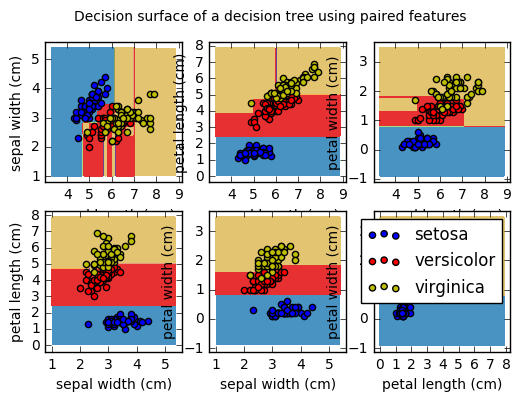

In [1]:
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

# Load data
iris = load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)

    plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()